In [1]:
import pandas as pd
import numpy as np

In [2]:
#read the datasets

train = pd.read_csv("train_data.csv")
val = pd.read_csv("valid_data.csv")
train.head()

,path,transcription,action,object,location
0,wavs/speakers/xRQE5VD7rRHVdyvM/7372ca00-45c4-1...,Turn on the kitchen lights,activate,lights,kitchen
1,wavs/speakers/R3mexpM2YAtdPbL7/dae28110-44fe-1...,Turn up the temperature,increase,heat,none
2,wavs/speakers/ZebMRl5Z7dhrPKRD/b55dcfd0-455d-1...,OK now switch the main language to Chinese,change language,Chinese,none
3,wavs/speakers/ppzZqYxGkESMdA5Az/61c54a20-4476-...,Turn down the bathroom temperature,decrease,heat,washroom
4,wavs/speakers/zaEBPeMY4NUbDnZy/8ef57ec0-44df-1...,Change the language,change language,none,none


At first glance the dataset looks like it comprises of commands. These commands have a certain object on which actions needs to be performed. We will try to analyze the dataset by finding how many uniques value in object, action and location we have 

In [3]:
train['action'].value_counts()

increase           2961
decrease           2852
activate           1901
deactivate         1537
change language    1267
bring              1048
Name: action, dtype: int64

In [4]:
train['object'].value_counts()

heat         3629
lights       2363
volume       2184
music         680
none          512
lamp          395
newspaper     274
shoes         266
socks         265
juice         243
Chinese       229
English       196
Korean        169
German        161
Name: object, dtype: int64

In [5]:
train['location'].value_counts()

none        7150
washroom    1958
kitchen     1273
bedroom     1185
Name: location, dtype: int64

Compare these unique value with the validation dataset 

In [6]:
val['action'].value_counts()

increase           822
decrease           769
activate           562
deactivate         439
change language    292
bring              234
Name: action, dtype: int64

After analyzing the unique values in dataset, we can see that there are 6 types of actions, 14 types of object and 4 types of location in the dataset. Thus, we can say that we need to train a multi-label classification model which will analyze all the three labels and identify correct labels from its reseoctive set of possibilities

We need to transform every label (action, location and object) into one-hot encoded format so that they can be passed in the model 

In [7]:
#one-hot encode actions 

action_list = []
action_list_val = []

action_dict = {
    'increase' : 0,
    'decrease' : 1,
    'activate' : 2,
    'deactivate' : 3,
    'change language' : 4,
    'bring' : 5
}

for action in train['action']:
    one_hot_action = [0] * len(action_dict.keys())
    one_hot_action[action_dict[action]] = 1
    action_list.append(np.array(one_hot_action))
    
for action in val['action']:
    one_hot_action = [0] * len(action_dict.keys())
    one_hot_action[action_dict[action]] = 1
    action_list_val.append(np.array(one_hot_action))

In [8]:
#one hot encode object

object_list = []
object_list_val = []

object_dict = {
    'heat' : 0,
    'lights' : 1,
    'volume' : 2,
    'music' : 3,
    'none' : 4,
    'lamp' : 5,
    'newspaper' : 6,
    'shoes' : 7,
    'socks' : 8,
    'juice' : 9,
    'Chinese' : 10,
    'English' : 11,
    'Korean' : 12,
    'German' : 13
}

for _object in train['object']:
    one_hot_object = [0] * len(object_dict.keys())
    one_hot_object[object_dict[_object]] = 1
    object_list.append(np.array(one_hot_object))
    
for _object in val['object']:
    one_hot_object = [0] * len(object_dict.keys())
    one_hot_object[object_dict[_object]] = 1
    object_list_val.append(np.array(one_hot_object))

In [9]:
#one hot encode location

location_list = []
location_list_val = []

location_dict = {
    'none' : 0,
    'washroom' : 1,
    'kitchen' : 2,
    'bedroom' : 3
}

for location in train['location']:
    one_hot_location = [0] * len(location_dict.keys())
    one_hot_location[location_dict[location]] = 1
    location_list.append(np.array(one_hot_location))

for location in val['location']:
    one_hot_location = [0] * len(location_dict.keys())
    one_hot_location[location_dict[location]] = 1
    location_list_val.append(np.array(one_hot_location))

We need to build a vocab which will consist of every word that is present in the dataset, 'transcription' column will help us in building the vocab

In [10]:
vocab = train['transcription']

To creat word-embeddings, we have used Glove embeddings as these are pre-trained embedding and we wont require to train them again to identify the relations between different words present in our vocab. This will help in improving performance of our model

In [11]:
from tqdm import tqdm
embedding_vector = {}
f = open('glove.6B.300d.txt')
for line in tqdm(f):
    value = line.split(' ')
    word = value[0]
    coef = np.array(value[1:],dtype = 'float32')
    embedding_vector[word] = coef

400000it [00:10, 36668.40it/s]


We will tokenize the text, using keras tokenizer

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
token = Tokenizer()
token.fit_on_texts(vocab)

In [13]:
vocab_size = len(token.word_index)+1
print(vocab_size)

99


We have to identify the maximum length of sentence/transcription present in the dataset. We require the maximum length  because we will pad every sentence upto the length of maximum sentence so that every sentence have same size.

In [14]:
max_length = 0
for command in train['transcription']:
    if len(command.split(' ')) > max_length:
        max_length = len(command.split(' '))
print(max_length)

10


We will do post-padding in the tokenized transcription as the padded tokens are not meaningful during learnning, therefore they are insignificant while training the model.  

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

seq = token.texts_to_sequences(list(train['transcription']))
pad_seq = pad_sequences(seq, maxlen=12, padding = 'post')

val_seq = token.texts_to_sequences(list(val['transcription']))
val_pad_seq = pad_sequences(val_seq, maxlen=12, padding = 'post')

create the embedding matrix which will contain all the embedding vectors of the vocabulary 

In [16]:
from tqdm import tqdm
embedding_matrix = np.zeros((vocab_size,300))
for word,i in tqdm(token.word_index.items()):
    embedding_value = embedding_vector.get(word)
    if embedding_value is not None:
        embedding_matrix[i] = embedding_value

100%|████████████████████████████████████████| 98/98 [00:00<00:00, 98903.22it/s]


In [17]:
embedding_matrix.shape

(99, 300)

convert the one-hot encoded labels into numpy array 

In [18]:
action_list = np.array(action_list)
location_list = np.array(location_list)
object_list = np.array(object_list)

action_list_val = np.array(action_list_val)
location_list_val = np.array(location_list_val)
object_list_val = np.array(object_list_val)

In [19]:
pad_seq.shape

(11566, 12)

In [20]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Bidirectional, Conv1D, Flatten

We have build a keras functional API model as there will be three outputs of the model comprising of each label, action, location and object. Each output will contain particular number of neurons which can be determined using the total number of unique values of label. For eg there are 4 unique locations in the dataset, therfore output layer correspinding to location will have 4 neurons. This will give us the probability of predicted label belonging to every possible location. 

In [21]:
inputs = Input(shape=(12,))
x = Embedding(vocab_size, 300, weights = [embedding_matrix], input_length=12, trainable = False)(inputs)
x = Bidirectional(LSTM(64))(x)
x = Dense(128, activation='relu')(x)
output_action = Dense(len(action_dict.keys()), activation='sigmoid', name='output_action')(x)
output_location = Dense(len(location_dict.keys()), activation='sigmoid', name='output_location')(x)
output_object = Dense(len(object_dict.keys()), activation='sigmoid', name='output_object')(x)

In [22]:
model = Model(inputs=inputs, outputs=[output_action, output_location, output_object])

In [23]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 12, 300)      29700       ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          186880      ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 128)          16512       ['bidirectional[0][0]']          
                                                                                              

In [25]:
history = model.fit(pad_seq, 
                    {'output_action': action_list, 
                     'output_location': location_list, 
                     'output_object': object_list}, 
                    validation_data = (val_pad_seq, (action_list_val, location_list_val, object_list_val)), #validation_split=0.2, 
                    epochs=8, 
                    batch_size=32,)

Epoch 1/8


2023-05-07 12:02:51.259575: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


362/362 [==============================] - 4s 7ms/step - loss: 0.2398 - output_action_loss: 0.0985 - output_location_loss: 0.0656 - output_object_loss: 0.0757 - output_action_accuracy: 0.8906 - output_location_accuracy: 0.9496 - output_object_accuracy: 0.8567 - val_loss: 0.0049 - val_output_action_loss: 0.0012 - val_output_location_loss: 5.9237e-04 - val_output_object_loss: 0.0031 - val_output_action_accuracy: 1.0000 - val_output_location_accuracy: 1.0000 - val_output_object_accuracy: 1.0000
Epoch 2/8
362/362 [==============================] - 2s 7ms/step - loss: 0.0021 - output_action_loss: 5.4604e-04 - output_location_loss: 2.6906e-04 - output_object_loss: 0.0012 - output_action_accuracy: 1.0000 - output_location_accuracy: 1.0000 - output_object_accuracy: 1.0000 - val_loss: 7.4483e-04 - val_output_action_loss: 2.1912e-04 - val_output_location_loss: 1.1610e-04 - val_output_object_loss: 4.0960e-04 - val_output_action_accuracy: 1.0000 - val_output_location_accuracy: 1.0000 - val_output_

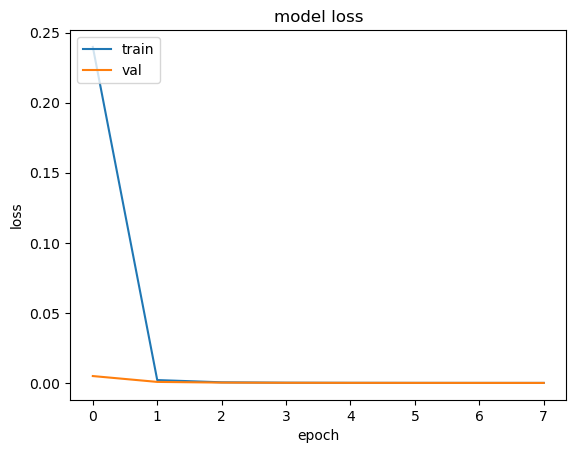

In [26]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

We can see from the graph that our model is not overfitting, we could use regularizer to prevent overfitting

In [27]:
#function to map predictied index in the label dictionary
def get_key(val, my_dict):
   
    for key, value in my_dict.items():
        if val == value:
            return key
 
    return "key doesn't exist"

In [28]:
sent_pred = 'Put on the music'
pred_tokens = token.texts_to_sequences([sent_pred])
pad_seq_pred = pad_sequences(pred_tokens, maxlen=12, padding = 'post')

prediction = model.predict(pad_seq_pred)

In [29]:
print(get_key(np.argmax(prediction[0]), action_dict))
print(get_key(np.argmax(prediction[1]), location_dict))
print(get_key(np.argmax(prediction[2]), object_dict))

activate
none
music
